<a href="https://colab.research.google.com/github/rajasekart7-arch/neural_network/blob/main/Raj_ML_DNN_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><font size=10>DNN - ReneWind</center></font>
<center><font size=6>Predict maintenance of the wind turbine for ReneWind</center></font>

## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S. Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).


### Objective

“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data on generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set, and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators can be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

True positives (TP) are failures correctly predicted by the model. These will result in repair costs.
False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
False positives (FP) are detections where there is no failure. These will result in inspection costs.
It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variable should be considered as “failure” and “0” represents “No failure”.


### Data Dictionary

The data provided is a transformed version of the original data which was collected using sensors.

Train.csv - To be used for training and tuning of models.
Test.csv - To be used only for testing the performance of the final best model.
Both datasets consist of 40 predictor variables and 1 target variable.


## Installing and Importing necessary libraries

In [347]:
# Installing the libraries with the specified version
!pip install --no-deps tensorflow==2.18.0 scikit-learn==1.3.2 matplotlib===3.8.3 seaborn==0.13.2 numpy==1.26.4 pandas==2.2.2 -q --user --no-warn-script-location

**Note**:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in ***this notebook***.

In [348]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import time

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpecFromSubplotSpec # Import for nested grids

sns.set()

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to split the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
)

import tensorflow as tf #An end-to-end open source machine learning platform
from tensorflow import keras  # High-level neural networks API for deep learning.
from keras import backend   # Abstraction layer for neural network backend engines.
from keras.models import Sequential  # Model for building NN sequentially.
from keras.layers import Dense, Dropout, BatchNormalization

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

## Loading the dataset

In [5]:
from os import path
# uncomment and run the following lines in case Google Colab is being used
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
# loading the dataset
path_train = "/content/drive/My Drive/Colab Notebooks/renewind_Train.csv"
path_test = "/content/drive/My Drive/Colab Notebooks/renewind_Test.csv"


data = pd.read_csv(path_train)
df_test= pd.read_csv(path_test)

## Data Overview

### Displaying the first few rows of the dataset

In [7]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.464606,-4.679129,3.101546,0.506130,-0.221083,-2.032511,-2.910870,0.050714,-1.522351,3.761892,-5.714719,0.735893,0.981251,1.417884,-3.375815,-3.047303,0.306194,2.914097,2.269979,4.394876,-2.388299,0.646388,-1.190508,3.132986,0.665277,-2.510846,-0.036744,0.726218,-3.982187,-1.072638,1.667098,3.059700,-1.690440,2.846296,2.235198,6.667486,0.443809,-2.369169,2.950578,-3.480324,0
1,3.365912,3.653381,0.909671,-1.367528,0.332016,2.358938,0.732600,-4.332135,0.565695,-0.101080,1.914465,-0.951458,-1.255259,-2.706522,0.193223,-4.769379,-2.205319,0.907716,0.756894,-5.833678,-3.065122,1.596647,-1.757311,1.766444,-0.267098,3.625036,1.500346,-0.585712,0.783034,-0.201217,0.024883,-1.795474,3.032780,-2.467514,1.894599,-2.297780,-1.731048,5.908837,-0.386345,0.616242,0
2,-3.831843,-5.824444,0.634031,-2.418815,-1.773827,1.016824,-2.098941,-3.173204,-2.081860,5.392621,-0.770673,1.106718,1.144261,0.943301,-3.163804,-4.247825,-4.038909,3.688534,3.311196,1.059002,-2.143026,1.650120,-1.660592,1.679910,-0.450782,-4.550695,3.738779,1.134404,-2.033531,0.840839,-1.600395,-0.257101,0.803550,4.086219,2.292138,5.360850,0.351993,2.940021,3.839160,-4.309402,0
3,1.618098,1.888342,7.046143,-1.147285,0.083080,-1.529780,0.207309,-2.493629,0.344926,2.118578,-3.053023,0.459719,2.704527,-0.636086,-0.453717,-3.174046,-3.404347,-1.281536,1.582104,-1.951778,-3.516555,-1.206011,-5.627854,-1.817653,2.124142,5.294642,4.748137,-2.308536,-3.962977,-6.028730,4.948770,-3.584425,-2.577474,1.363769,0.622714,5.550100,-1.526796,0.138853,3.101430,-1.277378,0
4,-0.111440,3.872488,-3.758361,-2.982897,3.792714,0.544960,0.205433,4.848994,-1.854920,-6.220023,1.998347,4.723757,0.709113,-1.989432,-2.632684,4.184447,2.245356,3.734452,-6.312766,-5.379918,-0.886667,2.061694,9.445586,4.489976,-3.945144,4.582065,-8.780422,-3.382967,5.106507,6.787513,2.044184,8.265896,6.629213,-10.068689,1.222987,-3.229763,1.686909,-2.163896,-3.644622,6.510338,0


### Checking the shape of the dataset

In [8]:
# checking shape of the data
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns.")

There are 20000 rows and 41 columns.


### Checking 10 random rows of the dataset

In [9]:
# let's view a sample of the data
data.sample(n=10, random_state=1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
11456,NaN,1.299595,4.382858,1.583219,-0.076564,0.658770,-1.638530,-4.814763,-0.914819,2.811808,0.571760,-0.318586,0.853250,-2.777201,-3.633432,-5.401728,-4.238895,0.261186,5.218141,-3.446377,-4.544353,-0.523904,-5.111638,3.632682,-2.314757,4.269501,-0.810190,-0.532287,0.692526,1.787281,0.724201,1.772287,5.755242,1.203739,5.663939,0.413630,-2.643934,5.529745,2.104536,-4.945350,0
16528,1.309352,0.720061,5.680574,-2.312339,0.880996,-1.359531,-0.058388,-0.145536,-0.753872,1.038636,-4.291862,0.945729,0.107877,-0.297047,1.078485,-1.387964,-0.200871,0.781839,-0.767055,-0.527947,-1.673416,-0.800456,-3.578860,-0.385550,2.796637,2.859383,2.774776,-1.755965,-2.938379,-4.989840,5.767124,-2.668198,-2.933937,-0.323589,-0.419004,6.313147,-0.102708,-1.698781,2.008471,2.112039,0
3253,2.519368,0.926495,7.726284,2.575956,-1.904331,-3.794748,-1.575311,-0.834651,1.692029,0.218210,-6.099308,1.255513,1.987956,-1.578651,-2.392113,-7.406792,2.144190,-0.384516,4.766871,3.782733,-8.242125,1.417503,-3.975549,0.519499,2.991440,2.752393,0.597670,-0.609844,-3.840043,-2.885797,1.126527,-2.652181,-4.292406,1.482631,5.237628,2.471868,-0.806991,-3.073952,1.039985,-2.610571,0
18614,-1.083353,0.532026,-0.978254,-2.810120,-0.492974,1.603178,0.037716,-0.909245,0.128591,-2.587226,3.446295,2.879979,2.151476,-1.783856,-2.235997,-0.422344,-1.188041,2.010517,-1.386026,-1.287588,-0.946813,0.198697,0.634323,-3.065059,-1.436533,0.659530,-0.865852,-1.436692,4.050820,3.454117,-3.654125,-4.397863,2.598824,-1.335465,-0.551914,-1.206368,2.151738,1.580007,0.756699,1.936813,0
1544,2.382206,-1.291732,1.446070,-2.806253,-2.575607,-3.092208,3.158156,5.643343,-3.243794,-0.620312,-1.327928,9.678155,-1.816689,-0.324585,6.045508,4.105225,4.299421,-1.479098,3.485214,3.964541,1.432257,0.413732,1.558259,-2.424783,3.383152,-4.725707,2.994816,1.370230,-0.328074,-1.866356,-0.943227,-8.410143,-9.004285,5.398941,-1.765375,3.480806,3.407376,-1.833117,0.819838,3.817818,0
12568,-4.870188,-1.918991,5.238484,-1.554154,2.659155,-0.248030,-5.956931,-3.781120,1.473329,1.151609,-6.028271,-3.446752,6.614106,0.322069,-11.518376,-8.004138,-3.892110,7.083940,-4.282603,-0.601526,-8.098256,1.337995,-1.449908,2.725048,-1.493587,5.832249,-2.659746,-4.524303,-3.263466,0.245013,4.801220,7.418596,5.769628,-6.196582,4.094840,7.185996,-0.508362,-4.190639,3.260319,-2.663106,0
15497,-4.105590,0.784265,-0.118861,2.244947,1.738429,-1.529195,-0.993154,3.037597,-2.356449,-0.826839,-0.448978,2.889340,0.147595,-0.968120,-2.460060,2.514937,1.271303,0.246790,1.304197,-0.537584,-0.507245,-0.387542,3.139941,5.336995,-3.362426,2.111352,-6.884402,-0.434596,1.948168,4.518584,1.496270,8.136924,4.271175,-1.566701,3.405943,-0.909253,-0.302684,-0.910550,-0.944579,-1.115742,0
13987,4.735340,0.460397,-1.437002,-4.849922,-0.698581,2.097795,1.511561,-2.167501,0.751953,0.246888,2.576309,0.270691,1.712827,0.342573,0.581357,-1.560444,-3.910292,1.120718,-2.420664,-4.417950,-1.365645,2.276387,1.273685,-2.755011,0.909004,0.329883,5.793481,-1.498824,-0.968165,-1.808646,-0.121719,-3.587484,-0.700452,-1.953658,-1.431061,0.465966,-0.002382,1.980842,0.304878,1.890984,0
9598,1.398675,-0.111943,8.514096,6.260541,-3.868094,-5.044732,-3.450308,-0.870352,1.822619,0.674053,-5.448328,1.729947,3.388807,-2.578363,-6.059598,-10.387770,1.919478,-1.073131,9.754322,5.527433,-12.995816,2.745051,-3.601838,3.475446,0.895095,2.393234,-2.858514,-0.020030,-2.415655,2.370390,-1.481550,1.748034,-0.911102,2.274900,12.148656,-0.941052,-2.158577,-3.546346,-0.085518,-7.421619,0
6668,2.799615,1.034590,1.380822,-5.960668,-1.067124,0.274000,0.822101,0.365555,0.876595,-4.197068,0.849268,5.514926,3.660541,-1.736744,-1.412948,-1.642396,0.186146,3.077226,-3.376772,-0.352551,-3.330002,1.567455,1.141919,-6.116524,1.666901,1.238903,2.158043,-3.010743,1.950388,0.032354,-2.309916,-9.524660,-2.511573,-2.479212,-1.994637,1.971598,3

**Observations**


In [10]:
# let's create a copy of the data to avoid any changes to original data
df = data.copy()

### Checking the data types of the columns for the dataset

In [11]:
# checking column datatypes and number of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

**Observations**

- There are 40 features and 1 target variable.
- All the feature values are in float and only 2 columns have the problem of missing value
- The target variable is int - 0 or 1

### Checking for duplicate values

In [12]:
# checking for duplicate values
df.duplicated().sum()

np.int64(0)

- There are no duplicate values

### Checking for missing values

In [13]:
df.isnull().sum()

,0
V1,18
V2,18
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0
V10,0


* V1 and V2 has the missing values of 18

In [14]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,19982.0,-0.271996,3.441625,-11.876451,-2.737146,-0.747917,1.840112,15.493002
V2,19982.0,0.440430,3.150784,-12.319951,-1.640674,0.471536,2.543967,13.089269
V3,20000.0,2.484699,3.388963,-10.708139,0.206860,2.255786,4.566165,17.090919
V4,20000.0,-0.083152,3.431595,-15.082052,-2.347660,-0.135241,2.130615,13.236381
V5,20000.0,-0.053752,2.104801,-8.603361,-1.535607,-0.101952,1.340480,8.133797
V6,20000.0,-0.995443,2.040970,-10.227147,-2.347238,-1.000515,0.380330,6.975847
V7,20000.0,-0.879325,1.761626,-7.949681,-2.030926,-0.917179,0.223695,8.006091
V8,20000.0,-0.548195,3.295756,-15.657561,-2.642665,-0.389085,1.722965,11.679495
V9,20000.0,-0.016808,2.160568,-8.596313,-1.494973,-0.067597,1.409203,8.137580
V10,20000.0,-0.012998,2.193201,-9.853957,-1.411212,0.100973,1.477045,8.108472


Looks like all the features are already normalized, the Std, mean, min and max are almost in the similar range

In [18]:
numeric_columns = list(data.select_dtypes(include=['int64', 'float64']))

numeric_columns.remove('Target')

target = 'Target'


## <a name='link2'>Exploratory Data Analysis (EDA) Summary</a>

### **ED Functions**

In [30]:
def plot_histogram_boxplot(data, features, figsize=(16, 70), kde=False, bins=None):
    """
    Generates a grid of combined boxplots and histograms.

    data: pandas DataFrame
    features: A single column name (string) or a list of column names
    figsize: Overall size of the figure
    kde: Whether to show the density curve on histograms
    bins: Number of bins for histograms
    """
    if not isinstance(features, list):
        features = [features]

    n_features = len(features)
    n_cols = min(n_features, 3)
    n_rows = int(np.ceil(n_features / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, constrained_layout=True)
    axes = np.array(axes).flatten()

    for i, feature in enumerate(features):
        current_ax = axes[i]
        current_ax.set_axis_off()

        # FIX: Use GridSpecFromSubplotSpec for a robust nested grid
        sub_gs = GridSpecFromSubplotSpec(
            2, 1,
            subplot_spec=current_ax.get_subplotspec(),
            height_ratios=[0.25, 0.75],
            hspace=0
        )

        ax_box = fig.add_subplot(sub_gs[0])
        ax_hist = fig.add_subplot(sub_gs[1], sharex=ax_box)

        plt.setp(ax_box.get_xticklabels(), visible=False)

        # Plotting
        sns.boxplot(data=data, x=feature, ax=ax_box, showmeans=True, color="violet")
        ax_box.set_xlabel('')
        ax_box.set_title(f'Distribution of {feature}', weight='bold')

        plot_params = {'data': data, 'x': feature, 'kde': kde, 'ax': ax_hist}
        if bins:
            sns.histplot(**plot_params, bins=bins)
        else:
            sns.histplot(**plot_params)

        ax_hist.axvline(data[feature].mean(), color="green", linestyle="--", label=f"Mean: {data[feature].mean():.2f}")
        ax_hist.axvline(data[feature].median(), color="black", linestyle="-", label=f"Median: {data[feature].median():.2f}")
        ax_hist.legend(loc="upper right")

    # Hide any unused subplots
    for i in range(n_features, len(axes)):
        axes[i].set_axis_off()

    plt.show()

### Univariate Analysis

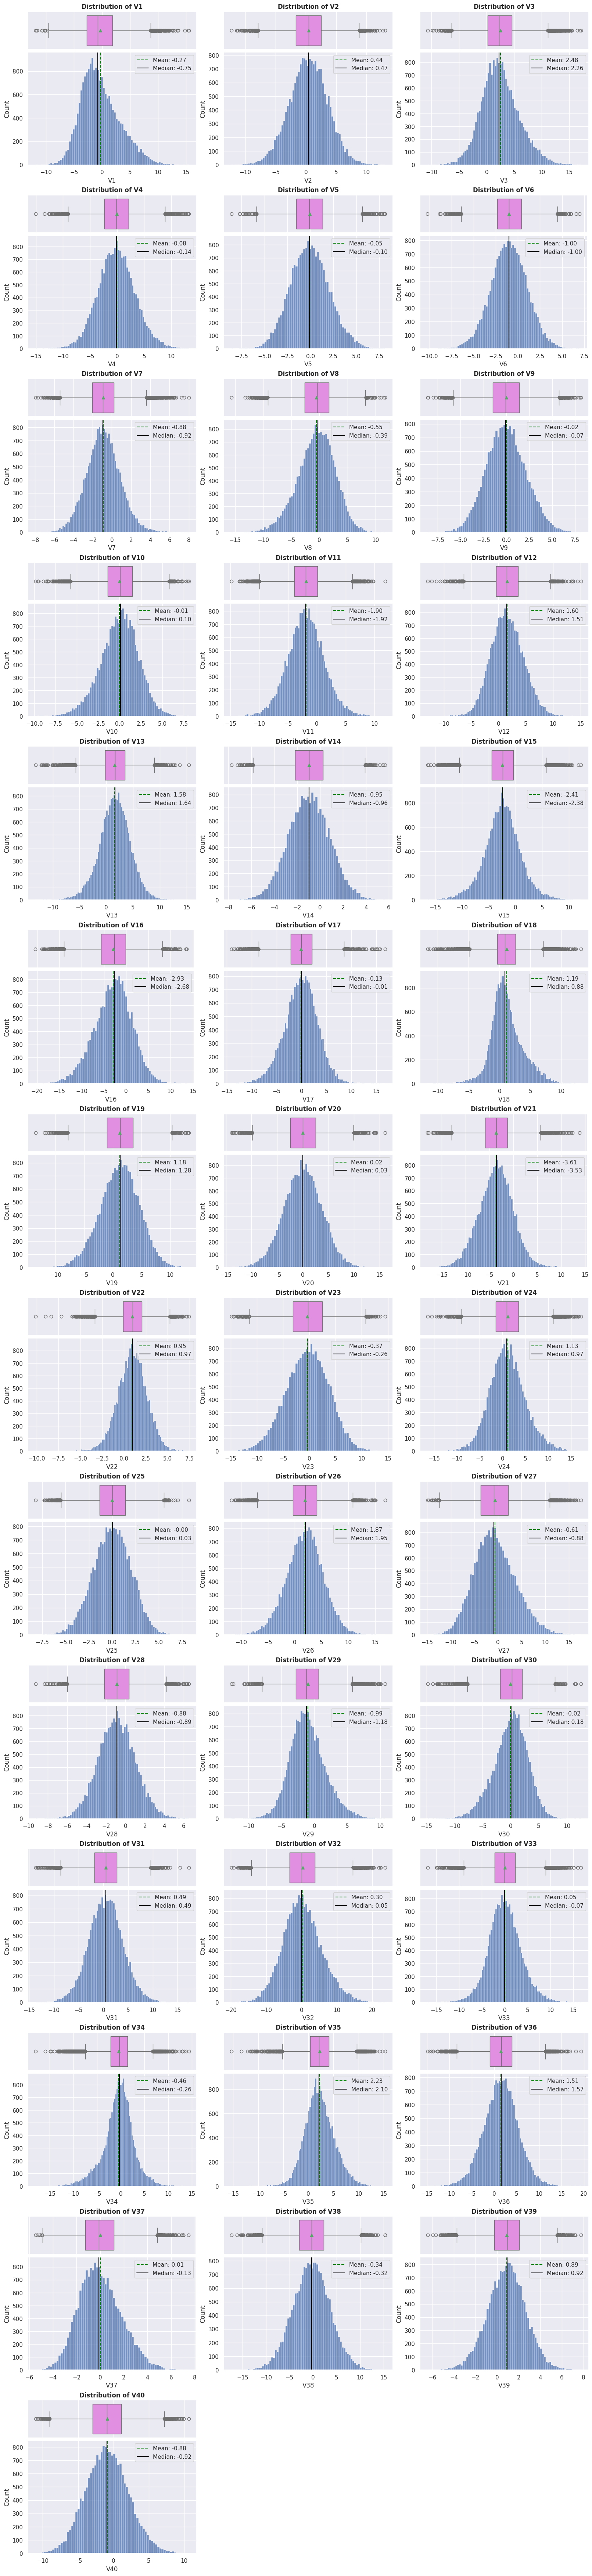

In [31]:
plot_histogram_boxplot(df, numeric_columns)



*   There are positive and negative outliers for all attributes "V1" to "V40"
* All the features are following normal distribution
*   The scale of attributes are more or less the same (somewhere between -20 to +20).
* Since not much is known about the attributes, the outliers will not be treated and are assumed to be real data trends

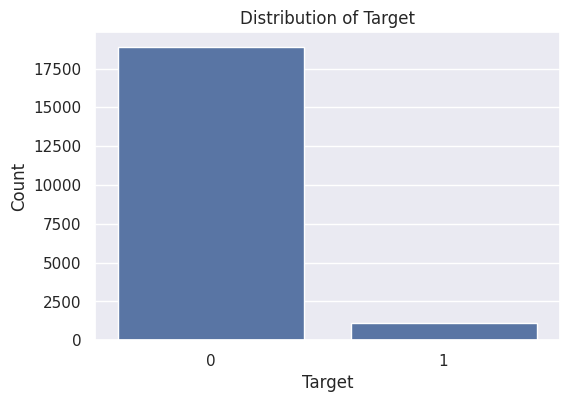

In [23]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df[target])   # countplot is for categorical frequency
plt.title(f"Distribution of {target}")
plt.xlabel(target)
plt.ylabel("Count")
plt.show()

In [24]:
df[target].value_counts()

,count
Target,
0,18890
1,1110


"Target" class is imbalanced with 18890 or 94.45% "No failures (i.e., 0)" and 1110 or 5.55% "Failures (i.e., 1)"
Since there is no categorical features and since the given features are already normalized and dont have a definite meaning to it, we will stop with the univariant analysis

In [32]:
df_test[target].value_counts()

,count
Target,
0,4718
1,282


Even in test test set the Failure is around 5.6%

## Data Preprocessing

### Train Test Split

In [42]:
# Dividing data into X and y
X = data.drop(["Target"], axis=1)
y = data["Target"]

X_test = df_test.drop(["Target"], axis=1) ##   drop target variable from test data
y_test = df_test["Target"] ##  store target variable in y_test

In [43]:
# Splitting data into training and validation set:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1) ##  split the data into train test in the ratio 75:25

print(X_train.shape, X_val.shape, X_test.shape)

(15000, 40) (5000, 40) (5000, 40)


### Handling null values

In [44]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum()[X_train.isna().sum() > 0])
print("-" * 30)
print(X_val.isna().sum()[X_val.isna().sum() > 0])
print("-" * 30)
print(X_test.isna().sum()[X_test.isna().sum() > 0])

V1    12
V2    15
dtype: int64
------------------------------
V1    6
V2    3
dtype: int64
------------------------------
V1    5
V2    6
dtype: int64


As highlighted earlier, V1 and V2 are having nulls, lets see how we can handle it

In [39]:
imputer = SimpleImputer(strategy="median")

In [45]:
# Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Transform the validation data
X_val =  pd.DataFrame(imputer.transform(X_val), columns=X_train.columns) ##  impute missing values in X_val

# Transform the test data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_train.columns) ##  impute missing values in X_test

In [46]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum()[X_train.isna().sum() > 0])
print("-" * 30)
print(X_val.isna().sum()[X_val.isna().sum() > 0])
print("-" * 30)
print(X_test.isna().sum()[X_test.isna().sum() > 0])

Series([], dtype: int64)
------------------------------
Series([], dtype: int64)
------------------------------
Series([], dtype: int64)


After using imputer function, there are no null values. All were replaced by median.

## Model building

### Model Evaluation Criteria

**The nature of predictions made by the classification model will translate as follows:**

* True positives (TP) are failures correctly predicted by the model.
* False negatives (FN) are real failures in a generator where there is no detection by model.
* False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

In [368]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target, probability):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred_prob = model.predict(predictors)

    pred = (pred_prob > probability).astype(int)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
        },
        index=[0],
    )

    return df_perf

In [369]:
def confusion_matrix_sklearn(model, predictors, target, probability):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred_prob = model.predict(predictors)

    y_pred = (y_pred_prob > probability).astype(int)

    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [71]:
def plot(history, name):
    """
    Function to plot loss/accuracy

    history: an object which stores the metrics and losses.
    name: can be one of Loss or Accuracy
    """
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name]) #Plotting the train accuracy or train loss
    plt.plot(history.history['val_'+name]) #Plotting the validation accuracy or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.

In [131]:
columns = ["# hidden layers","# neurons - hidden layer","activation function - hidden layer ","# epochs","batch size","optimizer","time(secs)","Train_loss","Valid_loss","Train_Recall","Valid_Recall"]

results = pd.DataFrame(columns=columns)

In [67]:
metrics = [
    keras.metrics.Recall(name="recall"),
#    keras.metrics.Precision(name="precision"),
#    keras.metrics.AUC(curve="PR", name="auc_pr"),
    ]

### Model 0 - Epoch 10

- We will start off with a simple neural network with
  - No Hidden layers
  - Gradient descent as the optimization algorithm.

In [132]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [133]:
#Initializing the neural network
model = Sequential()
model.add(Dense(1,input_dim=X_train.shape[1], activation="sigmoid"))

In [134]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

In [135]:
optimizer = keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [136]:
epochs = 10
batch_size = X_train.shape[0]

In [137]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - loss: 1.0629 - recall: 0.5387 - val_loss: 0.9599 - val_recall: 0.4964
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - loss: 0.9016 - recall: 0.5240 - val_loss: 0.8385 - val_recall: 0.5108
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.7788 - recall: 0.5325 - val_loss: 0.7467 - val_recall: 0.4856
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.6864 - recall: 0.5397 - val_loss: 0.6768 - val_recall: 0.4964
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.6168 - recall: 0.5481 - val_loss: 0.6228 - val_recall: 0.5000
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 0.5633 - recall: 0.5517 - val_loss: 0.5799 - val_recall: 0.5072
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.5215 - recall: 0.5481 - val_loss: 0.5451 - val_recall: 0.5216
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.4878 - recall: 0.5445 - val_loss: 0.5162 - val_recall: 0.5360
Epoch 9/10
1/1 ━━━━━━━━━

In [138]:
print("Time taken in seconds ",end-start)

Time taken in seconds  2.959007740020752


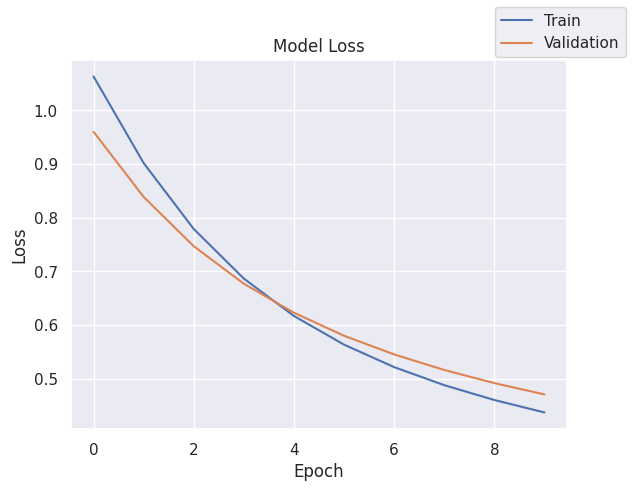

In [139]:
plot(history,'loss')

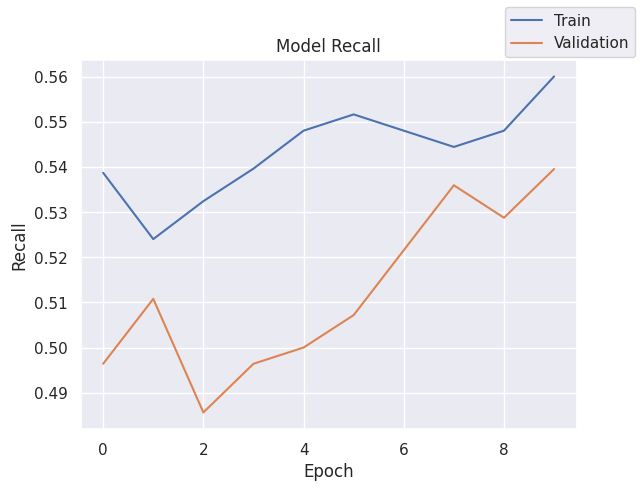

In [140]:
plot(history,'recall')

In [141]:
results.loc[0]=['-','-','-',epochs,batch_size,'GD',(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [142]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568


- Since it's a very simple neural network, the scores aren't good.
- The Recall is very bad

### Model 1 - Epoch 25

- Let's try increasing the epochs to check whether the performance is improving or not.

In [143]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [144]:
#Initializing the neural network
model = Sequential()
model.add(Dense(1,input_dim=X_train.shape[1], activation="sigmoid"))

In [145]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

In [146]:
optimizer = keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [147]:
epochs = 25
batch_size = X_train.shape[0]

In [148]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4448 - recall: 0.4820 - val_loss: 0.4267 - val_recall: 0.4137
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - loss: 0.4234 - recall: 0.4712 - val_loss: 0.4095 - val_recall: 0.4317
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step - loss: 0.4052 - recall: 0.4808 - val_loss: 0.3947 - val_recall: 0.4460
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step - loss: 0.3894 - recall: 0.4844 - val_loss: 0.3817 - val_recall: 0.4424
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.3756 - recall: 0.4880 - val_loss: 0.3703 - val_recall: 0.4388
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - loss: 0.3634 - recall: 0.4904 - val_loss: 0.3602 - val_recall: 0.4460
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.3525 - recall: 0.4964 - val_loss: 0.3510 - val_recall: 0.4460
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.3427 - recall: 0.5048 - val_loss: 0.3428 - val_recall: 0.4496
Epoch 9/25
1/1 ━━━━━━━━━━━━

In [149]:
print("Time taken in seconds ",end-start)

Time taken in seconds  8.933032512664795


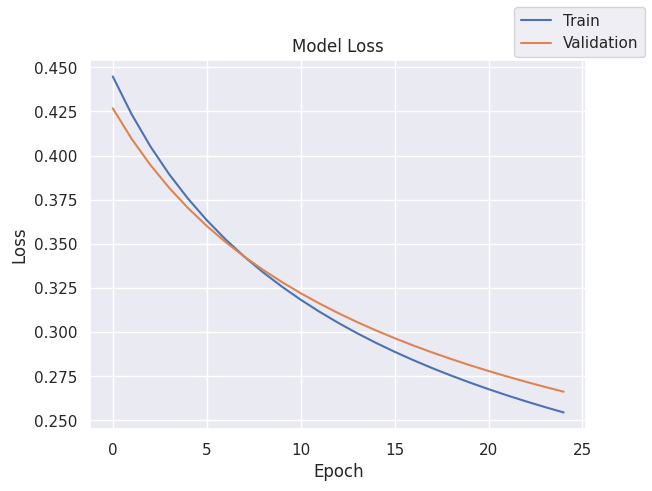

In [150]:
plot(history,'loss')

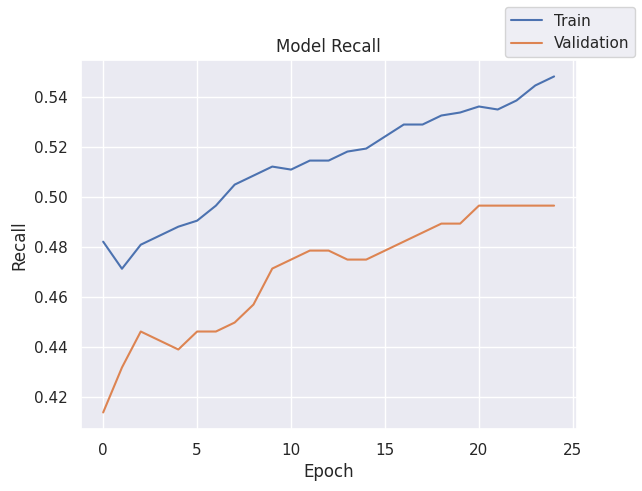

In [151]:
plot(history,'recall')

In [152]:
results.loc[1]=['-','-','-',epochs,batch_size,'GD',(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [153]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403


- Here also the performance of the model was not great




### Model 2 - SGD optimizer

- Let's now incorporate SGD to improve learning.
- Also, lets adjust the batch_size

In [154]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [155]:
#Initializing the neural network
model = Sequential()
model.add(Dense(1,input_dim=X_train.shape[1], activation="sigmoid"))

In [156]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

In [157]:
optimizer = keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [158]:
epochs = 25
batch_size = 32

In [159]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - loss: 0.2676 - recall: 0.5949 - val_loss: 0.1543 - val_recall: 0.5935
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 46s 70ms/step - loss: 0.1258 - recall: 0.6747 - val_loss: 0.1473 - val_recall: 0.5719
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - loss: 0.1197 - recall: 0.6730 - val_loss: 0.1425 - val_recall: 0.5576
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - loss: 0.1156 - recall: 0.6568 - val_loss: 0.1386 - val_recall: 0.5504
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.1124 - recall: 0.6448 - val_loss: 0.1355 - val_recall: 0.5324
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.1099 - recall: 0.6333 - val_loss: 0.1331 - val_recall: 0.5144
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.1079 - recall: 0.6274 - val_loss: 0.1311 - val_recall: 0.5036
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.1064 - recall: 0.6211 - val_loss: 0.1295 - val_recall:

In [160]:
print("Time taken in seconds ",end-start)

Time taken in seconds  562.3644003868103


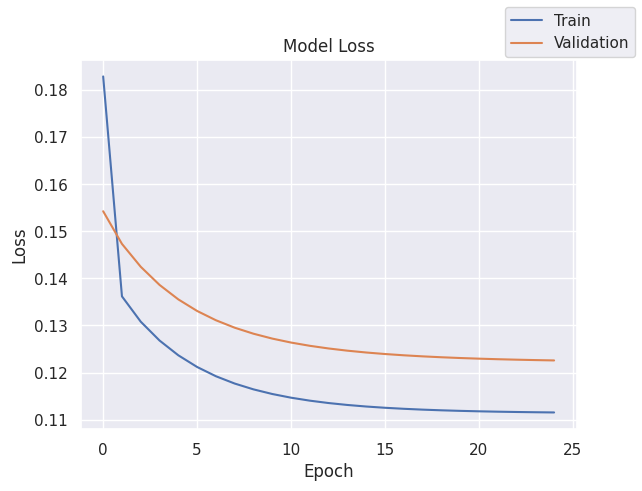

In [161]:
plot(history,'loss')

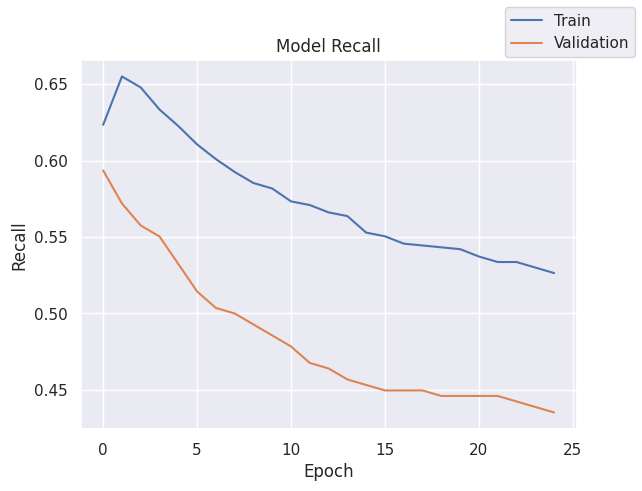

In [162]:
plot(history,'recall')

In [163]:
results.loc[2]=['-','-','-',epochs,batch_size,'SGD',(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [164]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252


- For this as well, the recall was very bad for both Train and Test

### Model 3 - batch size - 64

- Let's now increase the batch size to 64 to see if the performance improves.

In [165]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [166]:
#Initializing the neural network
model = Sequential()
model.add(Dense(1,input_dim=X_train.shape[1], activation="sigmoid"))

In [167]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

In [168]:
optimizer = keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [169]:
epochs = 25
batch_size = 64

In [170]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.3577 - recall: 0.5407 - val_loss: 0.1596 - val_recall: 0.5971
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.1320 - recall: 0.6881 - val_loss: 0.1543 - val_recall: 0.6007
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.1269 - recall: 0.6823 - val_loss: 0.1507 - val_recall: 0.5935
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.1235 - recall: 0.6802 - val_loss: 0.1477 - val_recall: 0.5791
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.1208 - recall: 0.6700 - val_loss: 0.1451 - val_recall: 0.5647
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.1185 - recall: 0.6678 - val_loss: 0.1427 - val_recall: 0.5576
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.1165 - recall: 0.6595 - val_loss: 0.1406 - val_recall: 0.5540
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.1147 - recall: 0.6575 - val_loss: 0.1387 - val_recall: 0.55

In [171]:
print("Time taken in seconds ",end-start)

Time taken in seconds  234.4375500679016


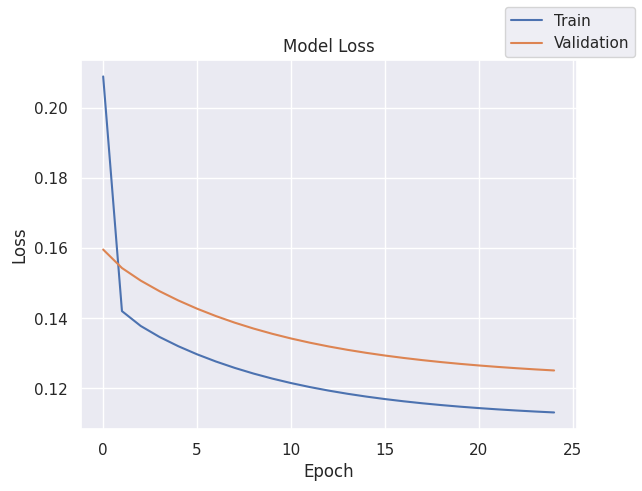

In [172]:
plot(history,'loss')

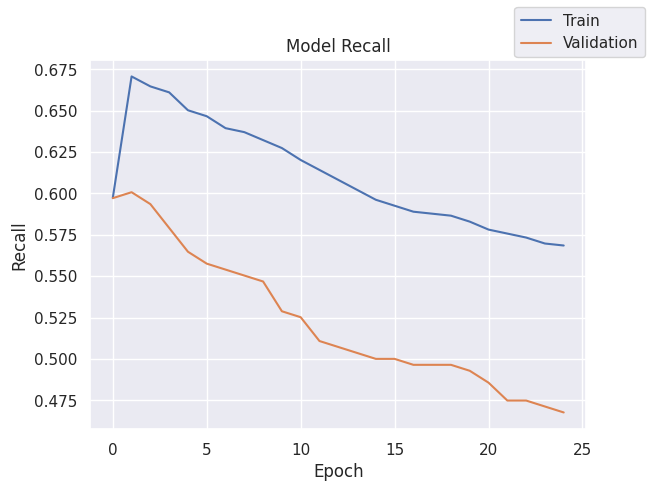

In [173]:
plot(history,'recall')

In [174]:
results.loc[3]=['-','-','-',epochs,batch_size,'SGD',(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [175]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626


- The performance hasn't improved, but the time taken to train the model has reduced.

### Model 4 - sigmoid activation

- Let's now add a hidden layer with 128 neurons.
- We'll use sigmoid as the activation function.

In [176]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [177]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="sigmoid",input_dim=X_train.shape[1]))
model.add(Dense(1,activation="sigmoid"))

In [178]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

In [179]:
optimizer = keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [180]:
epochs = 25
batch_size = 64

In [181]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.3448 - recall: 0.2780 - val_loss: 0.1657 - val_recall: 0.0216
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.1417 - recall: 0.0504 - val_loss: 0.1516 - val_recall: 0.1259
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.1285 - recall: 0.1529 - val_loss: 0.1426 - val_recall: 0.1906
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.1200 - recall: 0.2630 - val_loss: 0.1362 - val_recall: 0.2338
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.1140 - recall: 0.3340 - val_loss: 0.1313 - val_recall: 0.2626
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.1095 - recall: 0.3729 - val_loss: 0.1274 - val_recall: 0.3129
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.1059 - recall: 0.3984 - val_loss: 0.1244 - val_recall: 0.3345
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.1030 - recall: 0.4239 - val_loss: 0.1218 - val_recall:

In [182]:
print("Time taken in seconds ",end-start)

Time taken in seconds  291.24457931518555


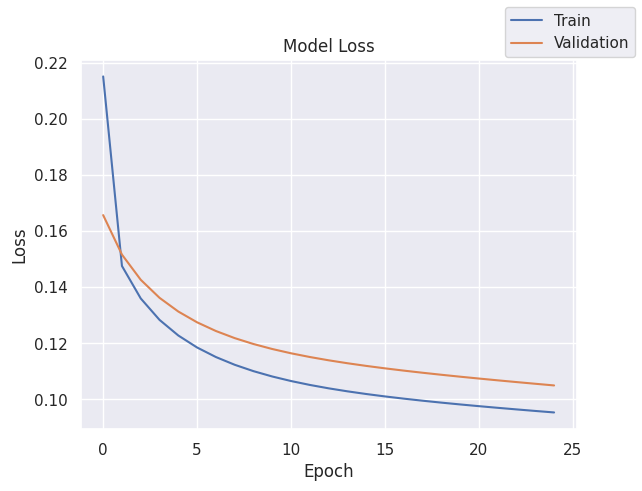

In [183]:
plot(history,'loss')

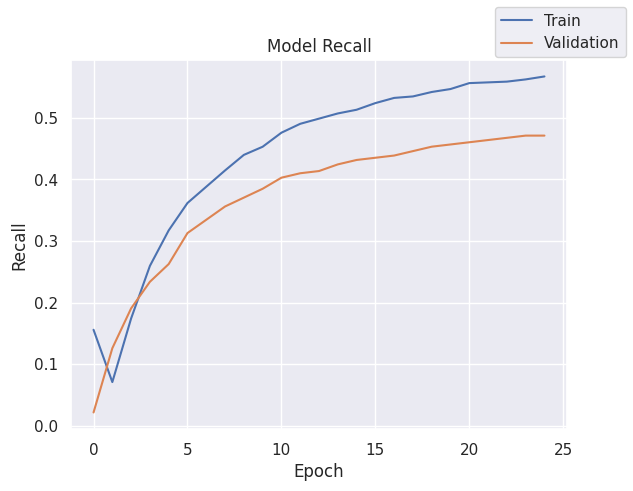

In [184]:
plot(history,'recall')

In [185]:
results.loc[4]=[1,128,'sigmoid',epochs,batch_size,'SGD',(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [186]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223


- We see the performance is still dipping
- The time taken too has not increased drastically.


### Model 5 - Tanh activation

- We'll now change the activation for the hidden layer from sigmoid to tanh.

In [187]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [188]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="tanh",input_dim=X_train.shape[1]))
model.add(Dense(1,activation="sigmoid"))

In [189]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

In [193]:
optimizer = keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [191]:
epochs = 25
batch_size = 64

In [194]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.3269 - recall: 0.5760 - val_loss: 0.1404 - val_recall: 0.5791
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 0.1153 - recall: 0.6878 - val_loss: 0.1201 - val_recall: 0.5791
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0992 - recall: 0.7039 - val_loss: 0.1094 - val_recall: 0.6007
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0904 - recall: 0.7272 - val_loss: 0.1019 - val_recall: 0.6223
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0841 - recall: 0.7415 - val_loss: 0.0962 - val_recall: 0.6367
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - loss: 0.0793 - recall: 0.7478 - val_loss: 0.0917 - val_recall: 0.6727
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - loss: 0.0754 - recall: 0.7624 - val_loss: 0.0880 - val_recall: 0.6906
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 0.0721 - recall: 0.7717 - val_loss: 0.0849 - val_recall:

In [195]:
print("Time taken in seconds ",end-start)

Time taken in seconds  328.7626283168793


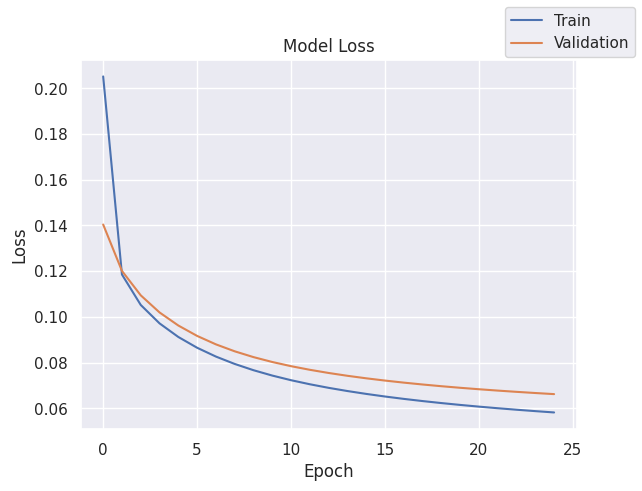

In [196]:
plot(history,'loss')

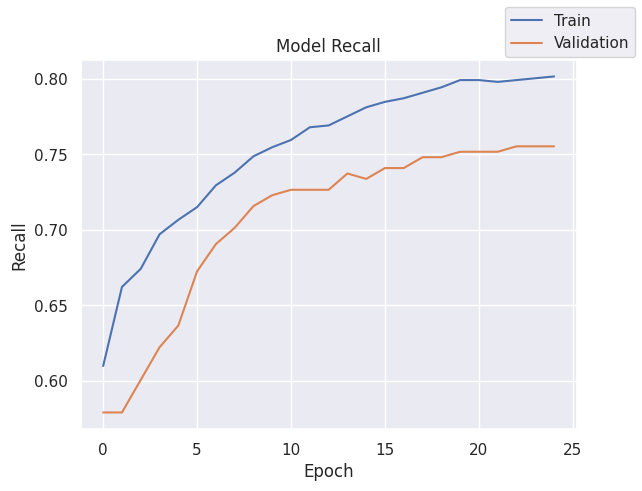

In [197]:
plot(history,'recall')

In [198]:
results.loc[5]=[1,128,'tanh',epochs,batch_size,'SGD',(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [199]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396


- Changing the activation has improved the recall %

### Model 6 - Relu activation

- We'll now change the activation for the hidden layer from tanh to relu

In [200]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [201]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(1, activation="sigmoid"))

In [202]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

In [203]:
optimizer = keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [204]:
epochs = 25
batch_size = 64

In [205]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.1692 - recall: 0.5061 - val_loss: 0.1135 - val_recall: 0.4856
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0903 - recall: 0.6120 - val_loss: 0.0980 - val_recall: 0.5971
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.0781 - recall: 0.6912 - val_loss: 0.0904 - val_recall: 0.6403
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0719 - recall: 0.7300 - val_loss: 0.0856 - val_recall: 0.6727
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0680 - recall: 0.7639 - val_loss: 0.0823 - val_recall: 0.6906
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0651 - recall: 0.7733 - val_loss: 0.0797 - val_recall: 0.7086
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0629 - recall: 0.7861 - val_loss: 0.0776 - val_recall: 0.7302
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.0610 - recall: 0.7920 - val_loss: 0.0759 - val_recall: 

In [206]:
print("Time taken in seconds ",end-start)

Time taken in seconds  272.1153094768524


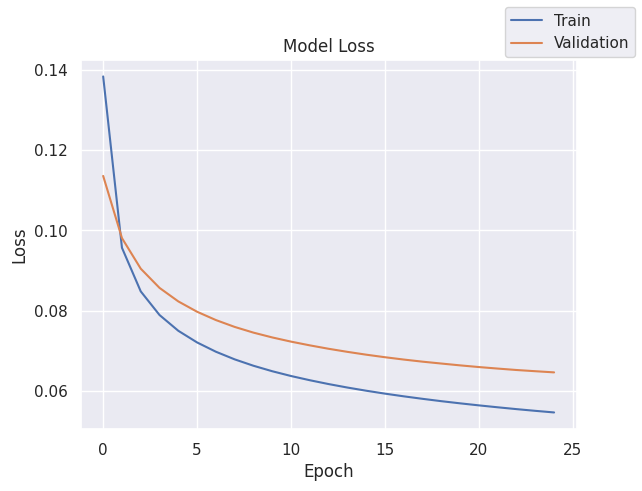

In [207]:
plot(history,'loss')

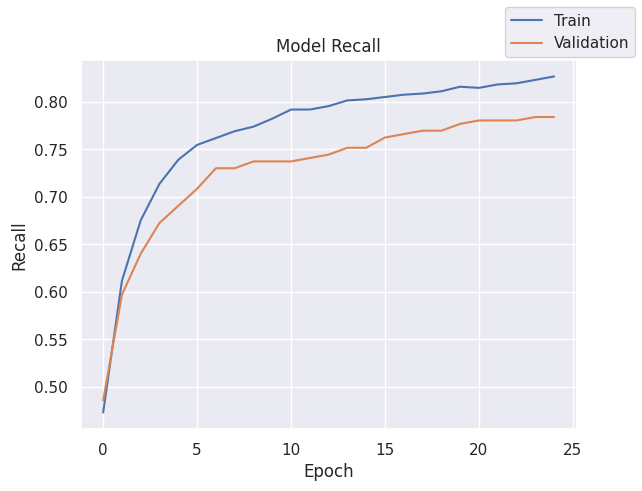

In [208]:
plot(history,'recall')

In [209]:
results.loc[6]=[1,128,'relu',epochs,batch_size,'SGD',(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [210]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173


- The performance got slightly improved



### Model 7 - addn Hidden layer

* We will now add one more hidden layer with 32 neurons.
* We'll use relu activation in both hidden layers.

In [211]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [212]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(32,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [213]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,409 (36.75 KB)

 Trainable params: 9,409 (36.75 KB)

 Non-trainable params: 0 (0.00 B)

In [214]:
optimizer = keras.optimizers.SGD()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [215]:
epochs = 25
batch_size = 64

In [216]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.2096 - recall: 0.4781 - val_loss: 0.1240 - val_recall: 0.4317
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0968 - recall: 0.5493 - val_loss: 0.0975 - val_recall: 0.5719
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0768 - recall: 0.6763 - val_loss: 0.0863 - val_recall: 0.6511
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0679 - recall: 0.7356 - val_loss: 0.0805 - val_recall: 0.6906
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0628 - recall: 0.7735 - val_loss: 0.0767 - val_recall: 0.7230
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0594 - recall: 0.7978 - val_loss: 0.0740 - val_recall: 0.7374
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0568 - recall: 0.8162 - val_loss: 0.0718 - val_recall: 0.7590
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 0.0547 - recall: 0.8193 - val_loss: 0.0700 - val_recall:

In [217]:
print("Time taken in seconds ",end-start)

Time taken in seconds  296.4396095275879


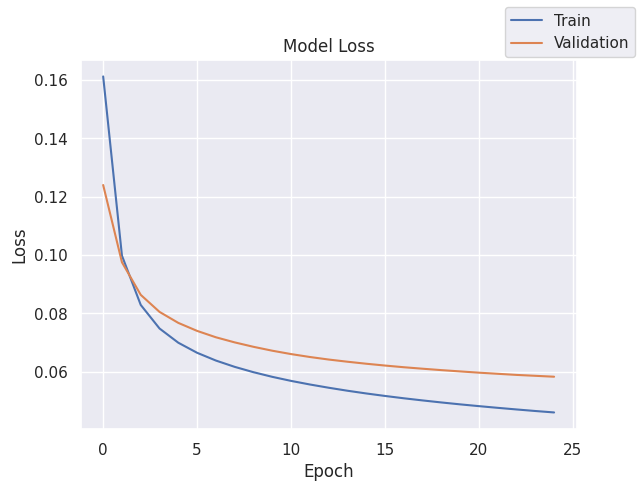

In [218]:
plot(history,'loss')

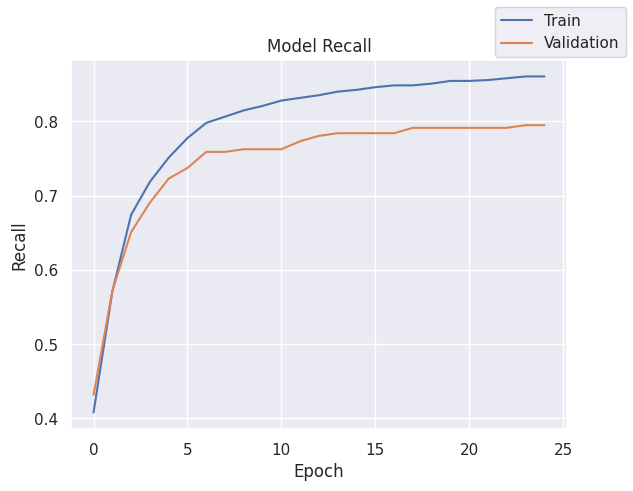

In [219]:
plot(history,'recall')

In [220]:
results.loc[7]=[2,[128,32],['relu','relu'],epochs,batch_size,'SGD',(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [221]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964


- Adding a hidden layer didn't improve the performance of the model.

### Model 8 - SGD mometum

* We will now add one more hidden layer with 32 neurons.
* We'll use relu activation in both hidden layers.
* Also, lets try SGD momentum=0.9

In [222]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [223]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(32,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [224]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,409 (36.75 KB)

 Trainable params: 9,409 (36.75 KB)

 Non-trainable params: 0 (0.00 B)

In [225]:
optimizer = keras.optimizers.SGD(momentum=0.9)    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [226]:
epochs = 25
batch_size = 64

In [227]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - loss: 0.2563 - recall: 0.6403 - val_loss: 0.0778 - val_recall: 0.7482
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0582 - recall: 0.8061 - val_loss: 0.0646 - val_recall: 0.7950
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0478 - recall: 0.8548 - val_loss: 0.0600 - val_recall: 0.8165
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0431 - recall: 0.8769 - val_loss: 0.0576 - val_recall: 0.8237
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0399 - recall: 0.8820 - val_loss: 0.0565 - val_recall: 0.8309
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 0.0373 - recall: 0.8836 - val_loss: 0.0560 - val_recall: 0.8381
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0353 - recall: 0.8841 - val_loss: 0.0555 - val_recall: 0.8417
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 0.0339 - recall: 0.8964 - val_loss: 0.0552 - val_recall:

In [228]:
print("Time taken in seconds ",end-start)

Time taken in seconds  333.1918885707855


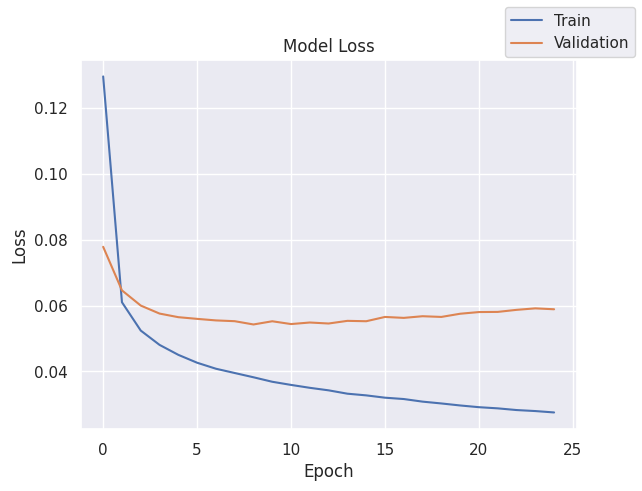

In [229]:
plot(history,'loss')

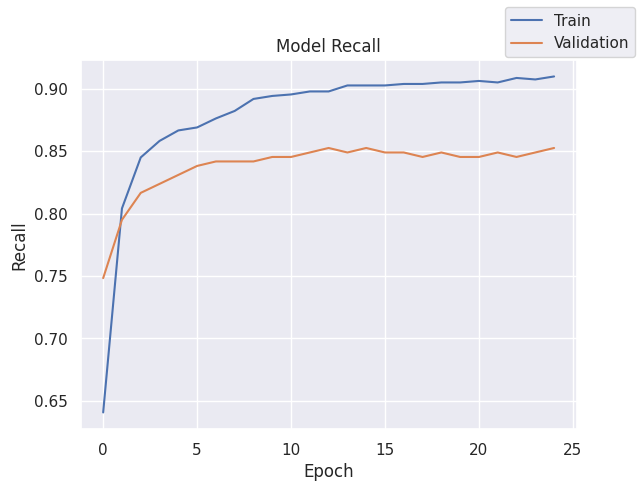

In [230]:
plot(history,'recall')

In [231]:
results.loc[8]=[2,[128,32],['relu','relu'],epochs,batch_size,['SGD', 'momemtum=0.9'],(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [232]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964
8,2,"[128, 32]","[relu, relu]",25,64,"[SGD, momemtum=0.9]",333.191889,0.027571,0.058865,0.909856,0.852518


- adding a momentum to SGD increased the model performance

### Model 9 - Adam

* Lets now try Adam optimizer

In [233]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [234]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="relu",input_dim=X_train.shape[1]))
model.add(Dense(32,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [235]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,409 (36.75 KB)

 Trainable params: 9,409 (36.75 KB)

 Non-trainable params: 0 (0.00 B)

In [236]:
optimizer = keras.optimizers.Adam()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [237]:
epochs = 25
batch_size = 64

In [238]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.1306 - recall: 0.6871 - val_loss: 0.0694 - val_recall: 0.7878
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 0.0519 - recall: 0.8428 - val_loss: 0.0599 - val_recall: 0.8273
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 0.0436 - recall: 0.8705 - val_loss: 0.0575 - val_recall: 0.8417
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 0.0396 - recall: 0.8825 - val_loss: 0.0552 - val_recall: 0.8525
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0364 - recall: 0.8893 - val_loss: 0.0539 - val_recall: 0.8561
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 0.0341 - recall: 0.9038 - val_loss: 0.0537 - val_recall: 0.8525
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - loss: 0.0325 - recall: 0.9034 - val_loss: 0.0533 - val_recall: 0.8561
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0312 - recall: 0.9070 - val_loss: 0.0531 - val_recall:

In [239]:
print("Time taken in seconds ",end-start)

Time taken in seconds  453.12862849235535


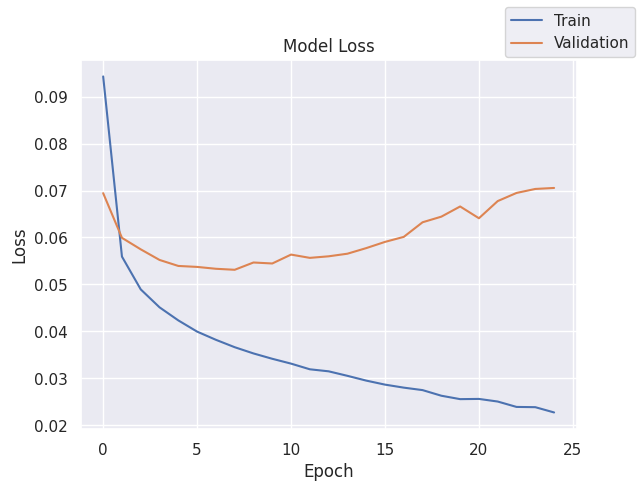

In [240]:
plot(history,'loss')

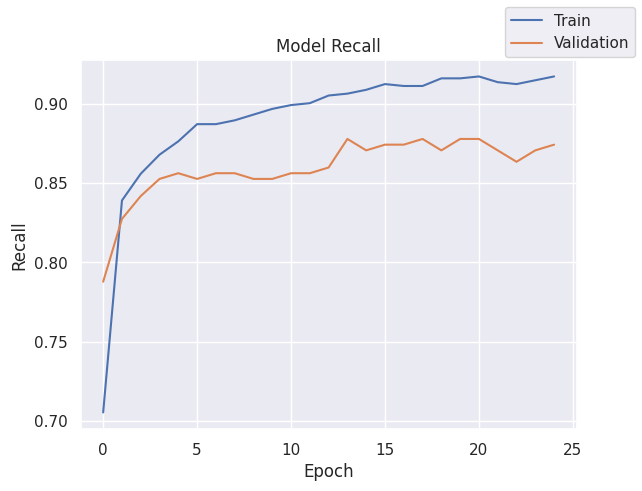

In [241]:
plot(history,'recall')

In [242]:
results.loc[9]=[2,[128,32],['relu','relu'],epochs,batch_size,'Adam',(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [243]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964
8,2,"[128, 32]","[relu, relu]",25,64,"[SGD, momemtum=0.9]",333.191889,0.027571,0.058865,0.909856,0.852518
9,2,"[128, 32]","[relu, relu]",25,64,Adam,453.128628,0.022732,0.070553,0.917067,0.874101


- Adding Adam increase the model performance by 2%

### Model 10 - dropout (0.4) regularization

* Let us now add a dropout regularization technique

In [244]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [245]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="relu",input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(32,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [246]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,409 (36.75 KB)

 Trainable params: 9,409 (36.75 KB)

 Non-trainable params: 0 (0.00 B)

In [247]:
optimizer = keras.optimizers.Adam()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [248]:
epochs = 25
batch_size = 64

In [249]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - loss: 0.2689 - recall: 0.6253 - val_loss: 0.0812 - val_recall: 0.6547
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 0.0781 - recall: 0.7095 - val_loss: 0.0668 - val_recall: 0.7482
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 0.0651 - recall: 0.7779 - val_loss: 0.0616 - val_recall: 0.7950
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.0564 - recall: 0.8089 - val_loss: 0.0564 - val_recall: 0.8237
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.0525 - recall: 0.8197 - val_loss: 0.0537 - val_recall: 0.8381
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.0507 - recall: 0.8541 - val_loss: 0.0514 - val_recall: 0.8525
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - loss: 0.0454 - recall: 0.8636 - val_loss: 0.0512 - val_recall: 0.8525
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.0432 - recall: 0.8738 - val_loss: 0.0515 - val_recall:

In [250]:
print("Time taken in seconds ",end-start)

Time taken in seconds  479.5527639389038


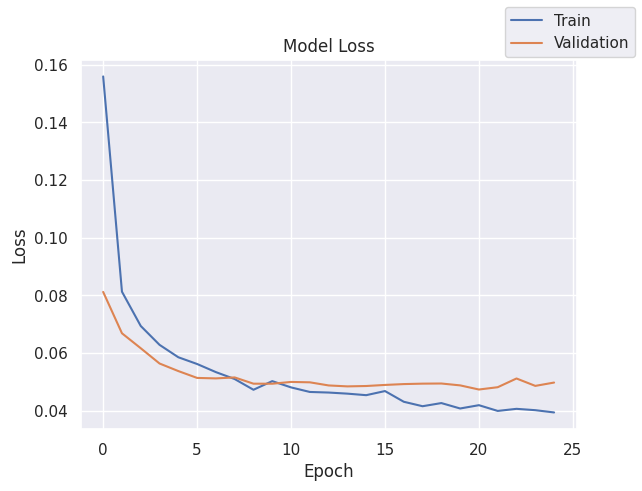

In [251]:
plot(history,'loss')

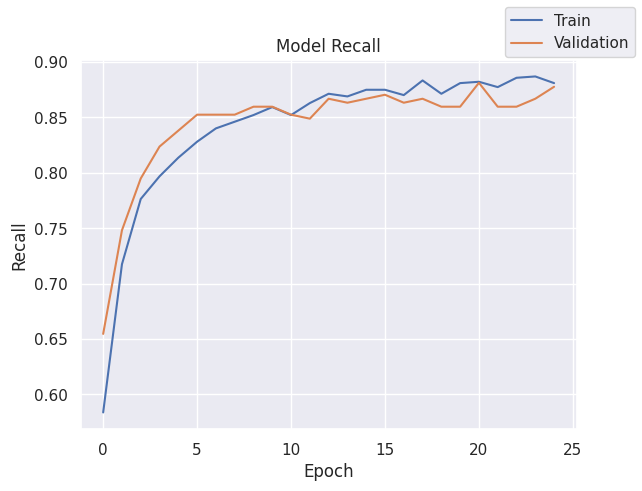

In [252]:
plot(history,'recall')

In [253]:
results.loc[10]=[2,[128,32],['relu','relu'],epochs,batch_size,['Adam','dropout=0.4'],(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [254]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964
8,2,"[128, 32]","[relu, relu]",25,64,"[SGD, momemtum=0.9]",333.191889,0.027571,0.058865,0.909856,0.852518
9,2,"[128, 32]","[relu, relu]",25,64,Adam,453.128628,0.022732,0.070553,0.917067,0.874101


- it has reduced the overfitting between train and test

### Model 11 - dropout (0.2) regularization

* Lets reduce the dropout and check

In [255]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [256]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="relu",input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(32,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [257]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,409 (36.75 KB)

 Trainable params: 9,409 (36.75 KB)

 Non-trainable params: 0 (0.00 B)

In [258]:
optimizer = keras.optimizers.Adam()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [259]:
epochs = 25
batch_size = 64

In [260]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.1599 - recall: 0.6721 - val_loss: 0.0695 - val_recall: 0.7446
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.0613 - recall: 0.7929 - val_loss: 0.0592 - val_recall: 0.8201
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.0521 - recall: 0.8359 - val_loss: 0.0562 - val_recall: 0.8309
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 0.0484 - recall: 0.8617 - val_loss: 0.0540 - val_recall: 0.8417
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 0.0450 - recall: 0.8624 - val_loss: 0.0538 - val_recall: 0.8309
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.0420 - recall: 0.8682 - val_loss: 0.0514 - val_recall: 0.8633
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.0417 - recall: 0.8825 - val_loss: 0.0502 - val_recall: 0.8669
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 0.0370 - recall: 0.8904 - val_loss: 0.0514 - val_recall:

In [261]:
print("Time taken in seconds ",end-start)

Time taken in seconds  482.80509209632874


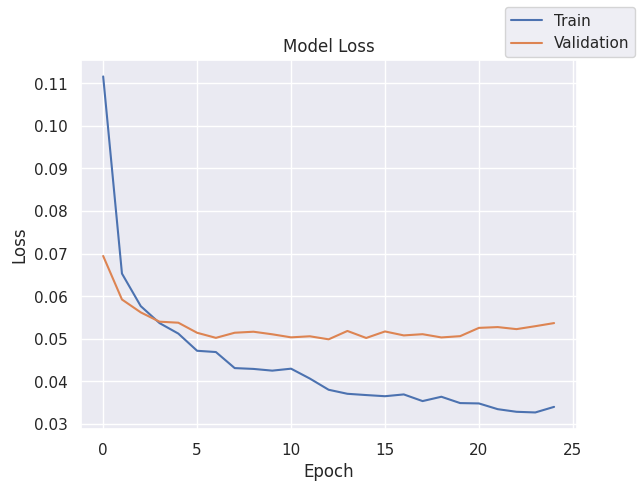

In [262]:
plot(history,'loss')

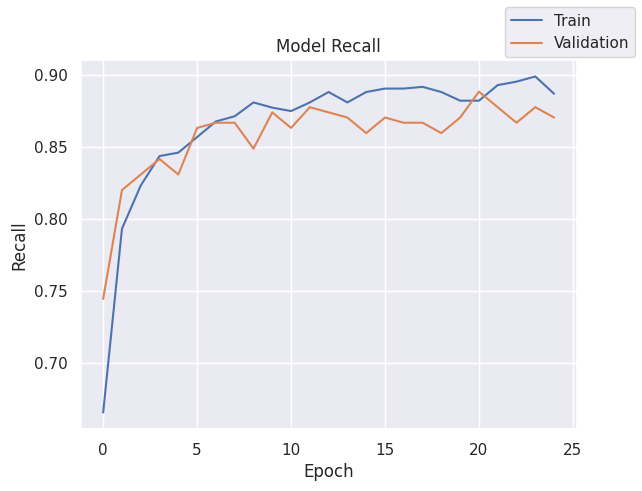

In [263]:
plot(history,'recall')

In [264]:
results.loc[11]=[2,[128,32],['relu','relu'],epochs,batch_size,['Adam','dropout=0.2'],(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [265]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964
8,2,"[128, 32]","[relu, relu]",25,64,"[SGD, momemtum=0.9]",333.191889,0.027571,0.058865,0.909856,0.852518
9,2,"[128, 32]","[relu, relu]",25,64,Adam,453.128628,0.022732,0.070553,0.917067,0.874101


- No drastic change but increased the gap between train and test and also execution time

### Model 12 - Batch normalization

* Let us now try the batch normalization technique

In [266]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [267]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="relu",input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dense(32,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1, activation="sigmoid"))

In [268]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,049 (39.25 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 320 (1.25 KB)

In [269]:
optimizer = keras.optimizers.Adam()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [270]:
epochs = 25
batch_size = 64

In [271]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - loss: 0.4915 - recall: 0.8678 - val_loss: 0.1016 - val_recall: 0.7554
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - loss: 0.0879 - recall: 0.8661 - val_loss: 0.0572 - val_recall: 0.7950
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - loss: 0.0456 - recall: 0.8708 - val_loss: 0.0526 - val_recall: 0.8094
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - loss: 0.0360 - recall: 0.8886 - val_loss: 0.0508 - val_recall: 0.8165
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - loss: 0.0320 - recall: 0.9003 - val_loss: 0.0576 - val_recall: 0.8345
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - loss: 0.0306 - recall: 0.9092 - val_loss: 0.0514 - val_recall: 0.8417
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - loss: 0.0277 - recall: 0.9112 - val_loss: 0.0522 - val_recall: 0.8525
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - loss: 0.0268 - recall: 0.9110 - val_loss: 0.0543 - val

In [272]:
print("Time taken in seconds ",end-start)

Time taken in seconds  674.9245736598969


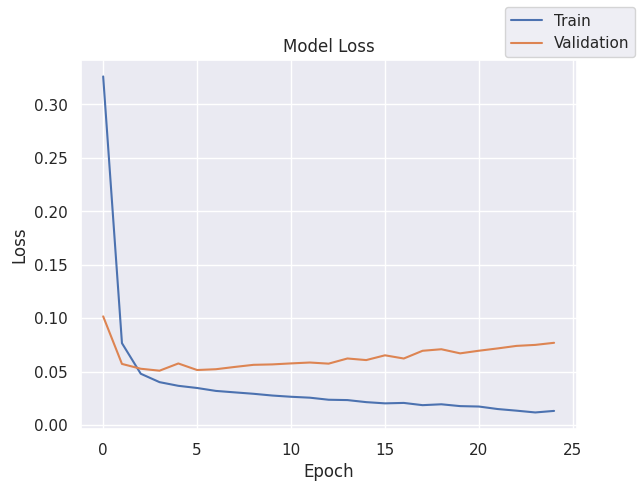

In [273]:
plot(history,'loss')

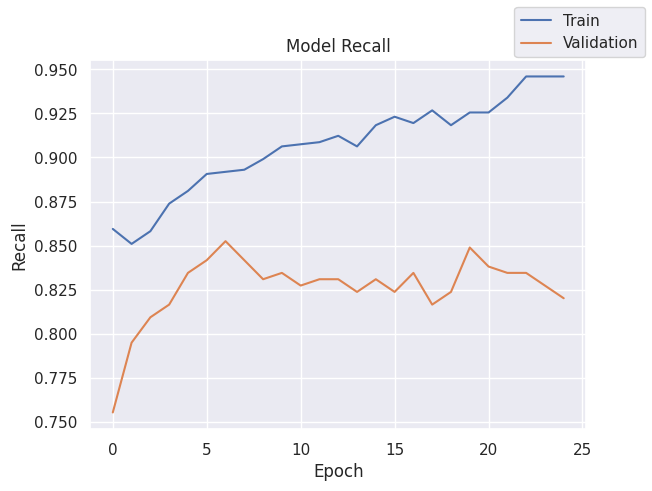

In [274]:
plot(history,'recall')

In [275]:
results.loc[12]=[2,[128,32],['relu','relu'],epochs,batch_size,['Adam','batch_norm'],(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [276]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964
8,2,"[128, 32]","[relu, relu]",25,64,"[SGD, momemtum=0.9]",333.191889,0.027571,0.058865,0.909856,0.852518
9,2,"[128, 32]","[relu, relu]",25,64,Adam,453.128628,0.022732,0.070553,0.917067,0.874101


- Model is overfitting and the performance got reduced

### Model 13 - dropout and class weight

* Let us know try the class weight and dropout technique together
* Since y is not balanced (94.5:5.5), we are applying weight to balance the performance

In [277]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights automatically
classes = np.unique(y_train)  # e.g., [0, 1]
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

# Convert to dictionary {class_label: weight}
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weight_dict)

Class Weights: {np.int64(0): np.float64(0.5293619424054207), np.int64(1): np.float64(9.014423076923077)}


In [278]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [279]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="relu",input_dim=X_train.shape[1]))
model.add(Dropout(0.4))
model.add(Dense(32,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [280]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,409 (36.75 KB)

 Trainable params: 9,409 (36.75 KB)

 Non-trainable params: 0 (0.00 B)

In [281]:
optimizer = keras.optimizers.Adam()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics, run_eagerly=True)

In [282]:
epochs = 25
batch_size = 64

In [283]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=class_weight_dict)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - loss: 0.5483 - recall: 0.8273 - val_loss: 0.2398 - val_recall: 0.8741
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - loss: 0.2720 - recall: 0.8925 - val_loss: 0.1801 - val_recall: 0.8885
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.2175 - recall: 0.9048 - val_loss: 0.1732 - val_recall: 0.8849
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.2213 - recall: 0.9089 - val_loss: 0.1781 - val_recall: 0.8741
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.1922 - recall: 0.9164 - val_loss: 0.1691 - val_recall: 0.8885
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.1921 - recall: 0.9179 - val_loss: 0.1518 - val_recall: 0.8741
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - loss: 0.1776 - recall: 0.9246 - val_loss: 0.1606 - val_recall: 0.8885
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 0.1794 - recall: 0.9186 - val_loss: 0.1562 - val_recall

In [284]:
print("Time taken in seconds ",end-start)

Time taken in seconds  501.6552231311798


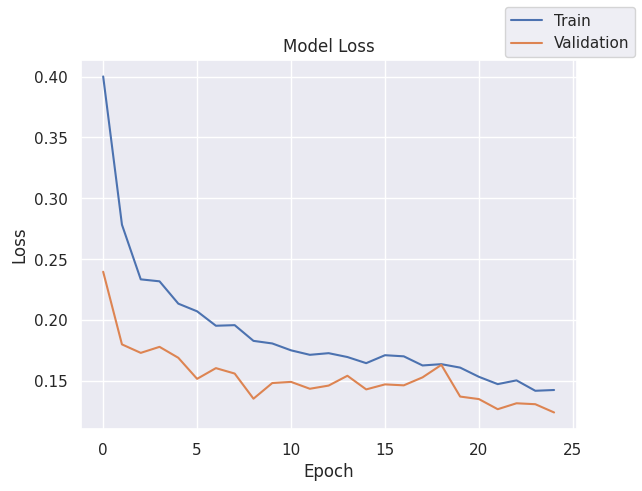

In [285]:
plot(history,'loss')

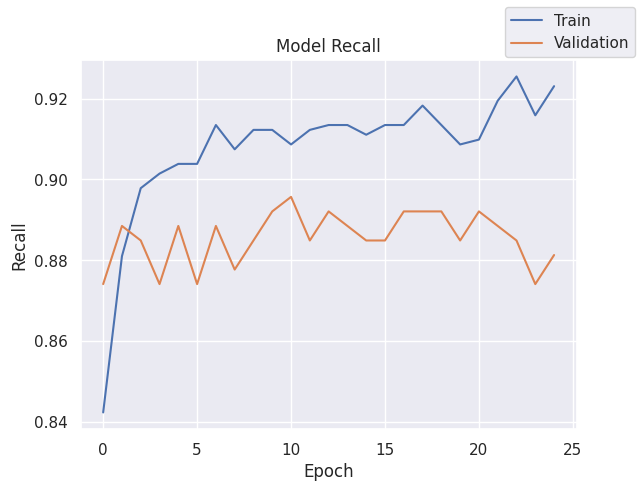

In [286]:
plot(history,'recall')

In [287]:
results.loc[13]=[2,[128,32],['relu','relu'],epochs,batch_size,['Adam','dropout=0.4','class_weight'],(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [288]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964
8,2,"[128, 32]","[relu, relu]",25,64,"[SGD, momemtum=0.9]",333.191889,0.027571,0.058865,0.909856,0.852518
9,2,"[128, 32]","[relu, relu]",25,64,Adam,453.128628,0.022732,0.070553,0.917067,0.874101


- it has reduced the overfitting and increased the performance of the model

### Model 14 - batch norm, dropout, class weight

* Lets apply all batch norm, dropout and class weight technique

In [289]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [290]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="relu",input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

In [291]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,049 (39.25 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 320 (1.25 KB)

In [292]:
optimizer = keras.optimizers.Adam()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [293]:
epochs = 25
batch_size = 64

In [294]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=class_weight_dict)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 161ms/step - loss: 0.5600 - recall: 0.8668 - val_loss: 0.2165 - val_recall: 0.8777
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - loss: 0.2748 - recall: 0.9091 - val_loss: 0.1486 - val_recall: 0.8777
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 123ms/step - loss: 0.2299 - recall: 0.9017 - val_loss: 0.1340 - val_recall: 0.8705
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 34s 145ms/step - loss: 0.2257 - recall: 0.9012 - val_loss: 0.1346 - val_recall: 0.8777
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 125ms/step - loss: 0.2091 - recall: 0.8988 - val_loss: 0.1237 - val_recall: 0.8885
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - loss: 0.2132 - recall: 0.9122 - val_loss: 0.1192 - val_recall: 0.8813
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 30s 128ms/step - loss: 0.1968 - recall: 0.9118 - val_loss: 0.1124 - val_recall: 0.8777
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 31s 131ms/step - loss: 0.1886 - recall: 0.9084 - val_loss: 0.1028 - val

In [295]:
print("Time taken in seconds ",end-start)

Time taken in seconds  833.2097551822662


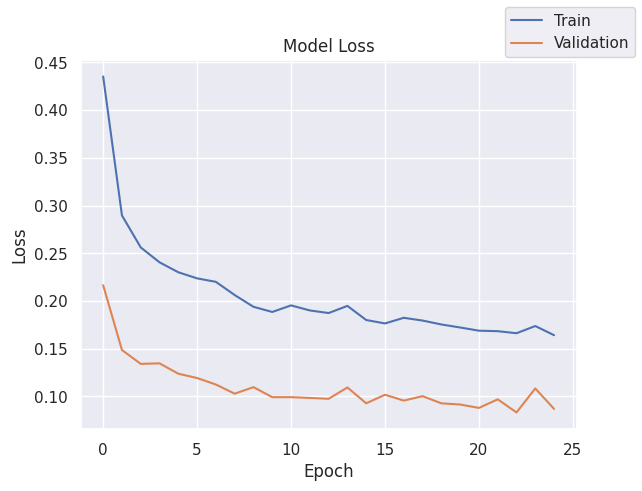

In [296]:
plot(history,'loss')

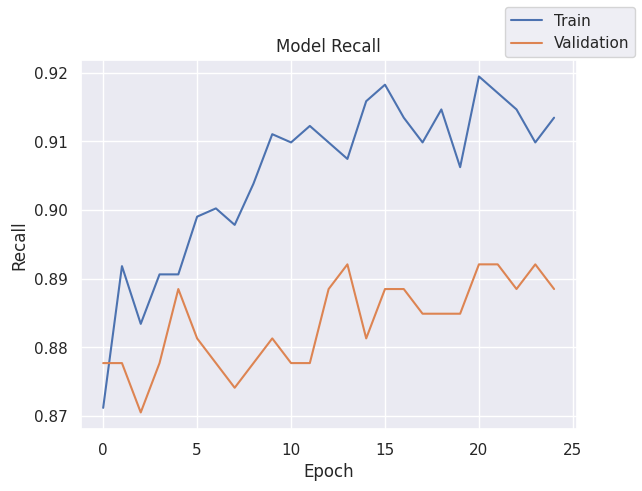

In [297]:
plot(history,'recall')

In [302]:
results.loc[14]=[2,[128,32],['relu','relu'],epochs,batch_size,['Adam','batchnorm','dropout=0.4,0.2','class_weight'],(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [303]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964
8,2,"[128, 32]","[relu, relu]",25,64,"[SGD, momemtum=0.9]",333.191889,0.027571,0.058865,0.909856,0.852518
9,2,"[128, 32]","[relu, relu]",25,64,Adam,453.128628,0.022732,0.070553,0.917067,0.874101


- the overfitting has further reduced and the performance also has slightly increase
- execution time has reduced.
- looks like this is the best model so far

### Model 15 - he normal and dropout

* Now lets change to he normalization

In [304]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [305]:
#Initializing the neural network
model = Sequential()
model.add(Dense(128,activation="relu",kernel_initializer="he_normal",input_dim=X_train.shape[1]))
#model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32,activation="relu",kernel_initializer="he_normal"))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

In [306]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,409 (36.75 KB)

 Trainable params: 9,409 (36.75 KB)

 Non-trainable params: 0 (0.00 B)

In [307]:
optimizer = keras.optimizers.Adam()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [308]:
epochs = 25
batch_size = 64

In [309]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=class_weight_dict)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - loss: 1.1328 - recall: 0.7935 - val_loss: 0.2769 - val_recall: 0.8849
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - loss: 0.3786 - recall: 0.8512 - val_loss: 0.2885 - val_recall: 0.8669
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.3272 - recall: 0.8667 - val_loss: 0.2913 - val_recall: 0.8561
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.2782 - recall: 0.8831 - val_loss: 0.2723 - val_recall: 0.8525
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.2819 - recall: 0.8793 - val_loss: 0.2213 - val_recall: 0.8453
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.2421 - recall: 0.8818 - val_loss: 0.2261 - val_recall: 0.8525
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.2261 - recall: 0.8991 - val_loss: 0.2130 - val_recall: 0.8669
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.2243 - recall: 0.8969 - val_loss: 0.2467 - val_recall:

In [310]:
print("Time taken in seconds ",end-start)

Time taken in seconds  538.7239089012146


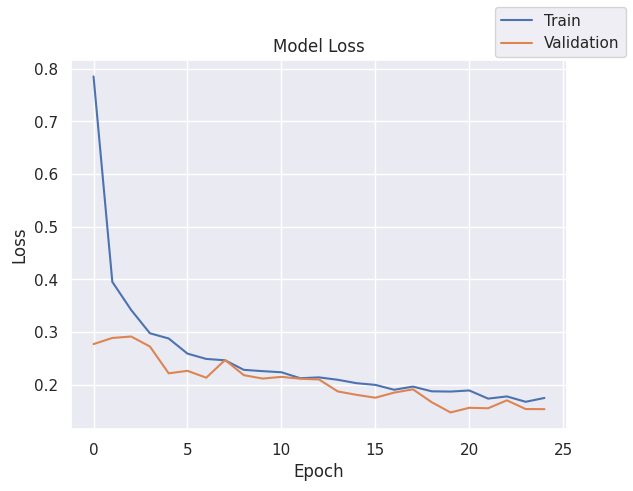

In [311]:
plot(history,'loss')

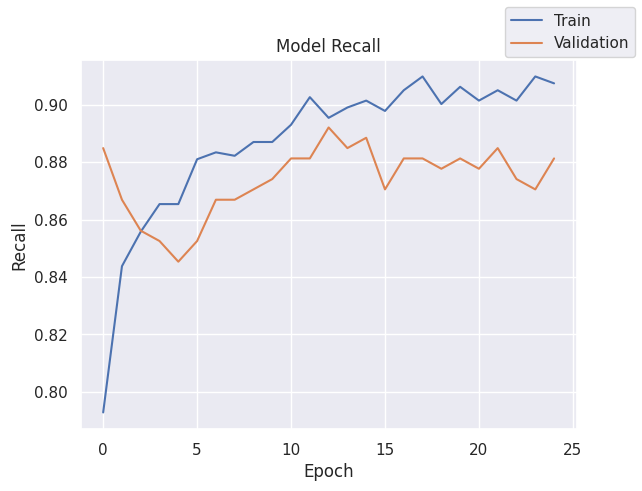

In [312]:
plot(history,'recall')

In [313]:
results.loc[15]=[2,[128,32],['relu','relu'],epochs,batch_size,['Adam','he_normal','dropout=0.4,0.2','class_weight'],(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [314]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964
8,2,"[128, 32]","[relu, relu]",25,64,"[SGD, momemtum=0.9]",333.191889,0.027571,0.058865,0.909856,0.852518
9,2,"[128, 32]","[relu, relu]",25,64,Adam,453.128628,0.022732,0.070553,0.917067,0.874101


- No drastic change, but the execution time increased

### Model 16 - he normal with one dropout

* reducing one layer of dropout

In [324]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [325]:
model = Sequential()
model.add(Dense(128,activation="relu",kernel_initializer="he_normal",input_dim=X_train.shape[1]))
#model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(32,activation="relu",kernel_initializer="he_normal"))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

In [326]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,409 (36.75 KB)

 Trainable params: 9,409 (36.75 KB)

 Non-trainable params: 0 (0.00 B)

In [327]:
optimizer = keras.optimizers.Adam()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [328]:
epochs = 25
batch_size = 64

In [329]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=class_weight_dict)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 0.6620 - recall: 0.8287 - val_loss: 0.3012 - val_recall: 0.8669
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - loss: 0.3192 - recall: 0.8722 - val_loss: 0.2164 - val_recall: 0.8597
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.2805 - recall: 0.8863 - val_loss: 0.1993 - val_recall: 0.8633
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - loss: 0.2322 - recall: 0.8946 - val_loss: 0.2377 - val_recall: 0.8957
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.2280 - recall: 0.9031 - val_loss: 0.1915 - val_recall: 0.8993
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - loss: 0.2281 - recall: 0.8985 - val_loss: 0.1814 - val_recall: 0.8885
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 0.1977 - recall: 0.9110 - val_loss: 0.1873 - val_recall: 0.8921
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.1936 - recall: 0.9125 - val_loss: 0.2003 - val_recall:

In [330]:
print("Time taken in seconds ",end-start)

Time taken in seconds  488.23976159095764


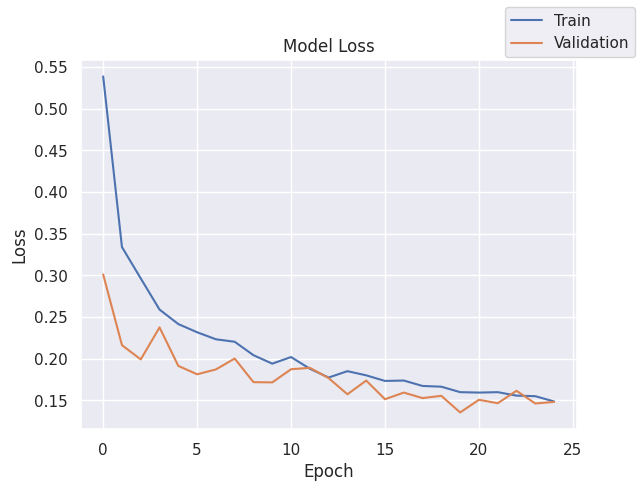

In [331]:
plot(history,'loss')

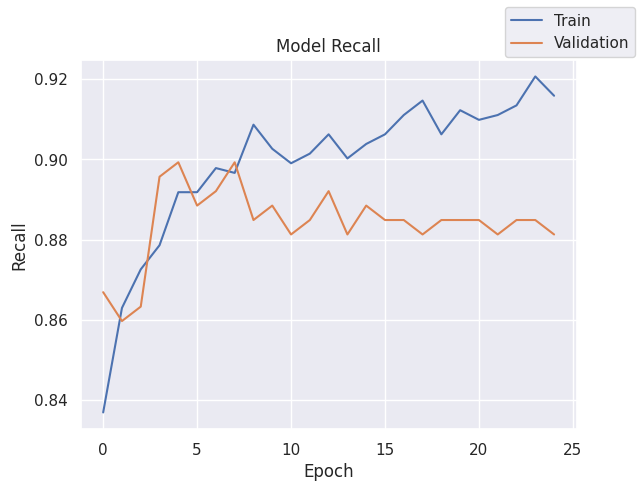

In [332]:
plot(history,'recall')

In [334]:
results.loc[16]=[2,[128,32],['relu','relu'],epochs,batch_size,['Adam','he_normal','dropout=0.4'],(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [335]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964
8,2,"[128, 32]","[relu, relu]",25,64,"[SGD, momemtum=0.9]",333.191889,0.027571,0.058865,0.909856,0.852518
9,2,"[128, 32]","[relu, relu]",25,64,Adam,453.128628,0.022732,0.070553,0.917067,0.874101


- No change in the performance of the model

### Model 17 - additional layer to model 14 (batch, dropout)

* Lets add one more hidden layer

In [336]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [337]:
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation="sigmoid"))

In [338]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,513 (64.50 KB)

 Trainable params: 16,065 (62.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [339]:
optimizer = keras.optimizers.Adam()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [340]:
epochs = 25
batch_size = 64

In [341]:
start = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs, class_weight=class_weight_dict)
end=time.time()

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 62s 262ms/step - loss: 0.6554 - recall: 0.8302 - val_loss: 0.2730 - val_recall: 0.8813
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 59s 163ms/step - loss: 0.3166 - recall: 0.8942 - val_loss: 0.1834 - val_recall: 0.8885
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - loss: 0.2684 - recall: 0.8914 - val_loss: 0.1661 - val_recall: 0.8885
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - loss: 0.2489 - recall: 0.9050 - val_loss: 0.1440 - val_recall: 0.8777
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 160ms/step - loss: 0.2249 - recall: 0.9108 - val_loss: 0.1340 - val_recall: 0.8813
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - loss: 0.2197 - recall: 0.9115 - val_loss: 0.1290 - val_recall: 0.8885
Epoch 7/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 166ms/step - loss: 0.2023 - recall: 0.9073 - val_loss: 0.1370 - val_recall: 0.8921
Epoch 8/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - loss: 0.2099 - recall: 0.9086 - val_loss: 0.1180 - val

In [342]:
print("Time taken in seconds ",end-start)

Time taken in seconds  1009.8936462402344


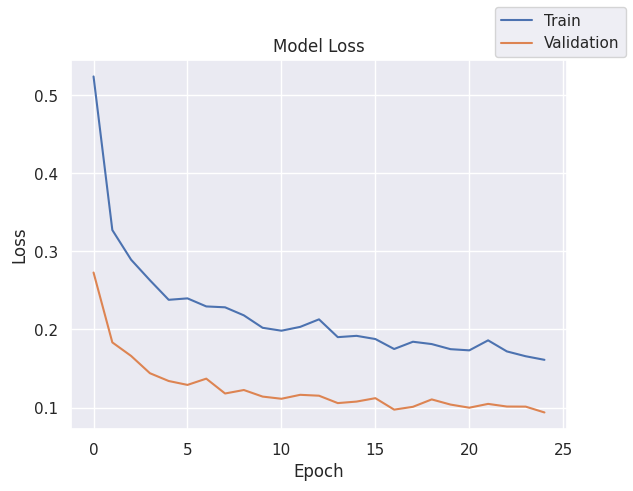

In [343]:
plot(history,'loss')

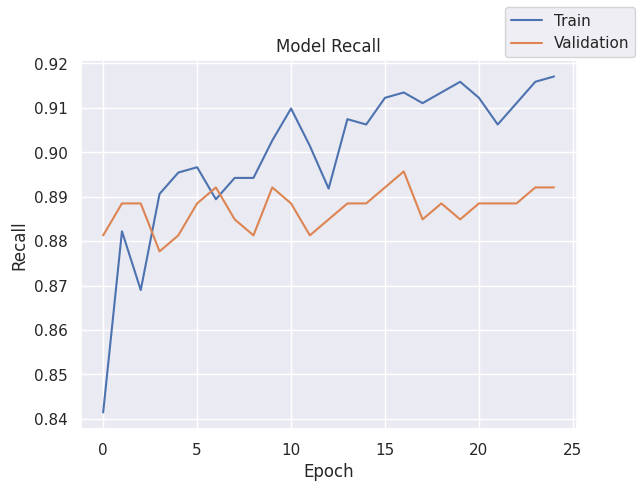

In [344]:
plot(history,'recall')

In [345]:
results.loc[17]=[2,[128,64,32],['relu','relu','relu'],epochs,batch_size,['Adam','batch_norm','dropout=0.4,0.3,0.2'],(end-start),history.history["loss"][-1],history.history["val_loss"][-1],history.history["recall"][-1],history.history["val_recall"][-1]]

In [346]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964
8,2,"[128, 32]","[relu, relu]",25,64,"[SGD, momemtum=0.9]",333.191889,0.027571,0.058865,0.909856,0.852518
9,2,"[128, 32]","[relu, relu]",25,64,Adam,453.128628,0.022732,0.070553,0.917067,0.874101


- So far this is the best result.
- slightly increase in the execution time when compared t model 14

## Model Performance Comparison and Final Model Selection

In [349]:
results

,# hidden layers,# neurons - hidden layer,activation function - hidden layer,# epochs,batch size,optimizer,time(secs),Train_loss,Valid_loss,Train_Recall,Valid_Recall
0,-,-,-,10,15000,GD,2.959008,0.437021,0.470592,0.560096,0.539568
1,-,-,-,25,15000,GD,8.933033,0.254516,0.266255,0.548077,0.496403
2,-,-,-,25,32,SGD,562.364400,0.111524,0.122572,0.526442,0.435252
3,-,-,-,25,64,SGD,234.437550,0.113124,0.125099,0.568510,0.467626
4,1,128,sigmoid,25,64,SGD,291.244579,0.095283,0.104924,0.567308,0.471223
5,1,128,tanh,25,64,SGD,328.762628,0.058140,0.066169,0.801683,0.755396
6,1,128,relu,25,64,SGD,272.115309,0.054617,0.064596,0.826923,0.784173
7,2,"[128, 32]","[relu, relu]",25,64,SGD,296.439610,0.045982,0.058239,0.860577,0.794964
8,2,"[128, 32]","[relu, relu]",25,64,"[SGD, momemtum=0.9]",333.191889,0.027571,0.058865,0.909856,0.852518
9,2,"[128, 32]","[relu, relu]",25,64,Adam,453.128628,0.022732,0.070553,0.917067,0.874101


- Among all other models, Model 17 and 14 achieved the highest training and validation scores.

- We can choose any one of them. Let's choose the model 17 as there is some difference in the train and valid scores and it seems to be realistic.


- We'll go ahead with this model as our final model.

- Let's rebuild it and check its performance across multiple metrics

## Final Model - on test

In [350]:
# clears the current Keras session, resetting all layers and models previously created, freeing up memory and resources.
tf.keras.backend.clear_session()

In [351]:
model = Sequential()
model.add(Dense(128, activation="relu", input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation="sigmoid"))

In [352]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,513 (64.50 KB)

 Trainable params: 16,065 (62.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [353]:
optimizer = keras.optimizers.Adam()    # defining SGD as the optimizer to be used
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics,run_eagerly=True)

In [354]:
epochs = 25
batch_size = 64

In [370]:
model_performance_classification_sklearn(model, X_test, y_test, 0.4)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


,Accuracy,Recall,Precision,F1
0,0.5624,0.783688,0.094123,0.168061


In [371]:
model_performance_classification_sklearn(model, X_test, y_test, 0.3)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


,Accuracy,Recall,Precision,F1
0,0.3134,0.875887,0.067764,0.125796


In [372]:
model_performance_classification_sklearn(model, X_test, y_test, 0.5)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step


,Accuracy,Recall,Precision,F1
0,0.764,0.666667,0.147567,0.241645


157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


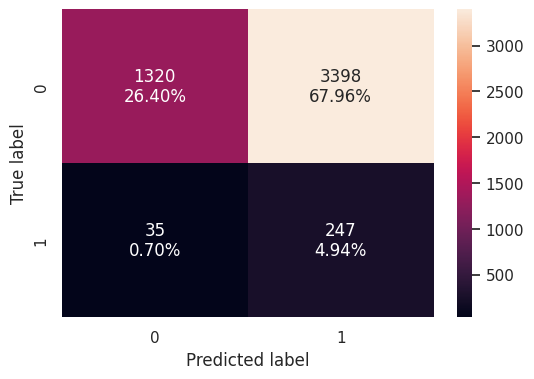

In [376]:
confusion_matrix_sklearn(model, X_test, y_test, 0.3)

- On setting the prob threshold to 30% we are getting recall of 87.5%

- Whereas the precision, accuracy and f1_score is very bad, but this is expected since we were concentrating on the

- Only 35 out of 282 are not predicted that is around 12%

- 3398 cases has to be inpected which is little off, can tweak the model if this needs to be reduced

## Business Insights and Recommendations

1. Our neural network model has successfully explained approximately 87% of the failures in the data.
2. But it has wrongly predicted the non-failure cases as well
3. Since the NN doesnt give the feature importance, we couldnt give a recommendation to the company on which feature needs to be concentrated on.
4. This can be further optimized to reduce the inspection cost by concentrating on the f1 score



